In [46]:
import numpy as np
import pandas as pd


We will be using Aurelion Gerons Machine Learning pipeline on the UC Irwin bikes dataset.
We will start from scratch and build our knowledge up from there.

The target variable is the number of bike rentals per hour or day. The number of samples in the hourly counted dataset is much higher, so we will be using that primarily. It will be interesting to see how the hourly model translates to daily logged predictions. 

It starts with importing the dataset into this colab notebook

In [47]:
data = pd.read_csv("https://raw.githubusercontent.com/BoldAxis0/Bikes-Regression/main/Bike-Sharing-Dataset/hour.csv")

Okay, lets take a look at this bad boy

In [48]:
data.describe()

,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,17379.0000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,8690.0000,2.501640,0.502561,6.537775,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869,189.463088
std,5017.0295,1.106918,0.500008,3.438776,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286,181.387599
min,1.0000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,4345.5000,2.000000,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000,40.000000
50%,8690.0000,3.000000,1.000000,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000,142.000000
75%,13034.5000,3.000000,1.000000,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000,281.000000
max,17379.0000,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000,977.000000


In [49]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


Thats a lot of numbers damn. Atleast its nice to know that we dont have any null values. Probably a lot of 0 values though. Do we have any way of distinguising these? Not sure at the moment.

I like graphs. Lets do some graphs.

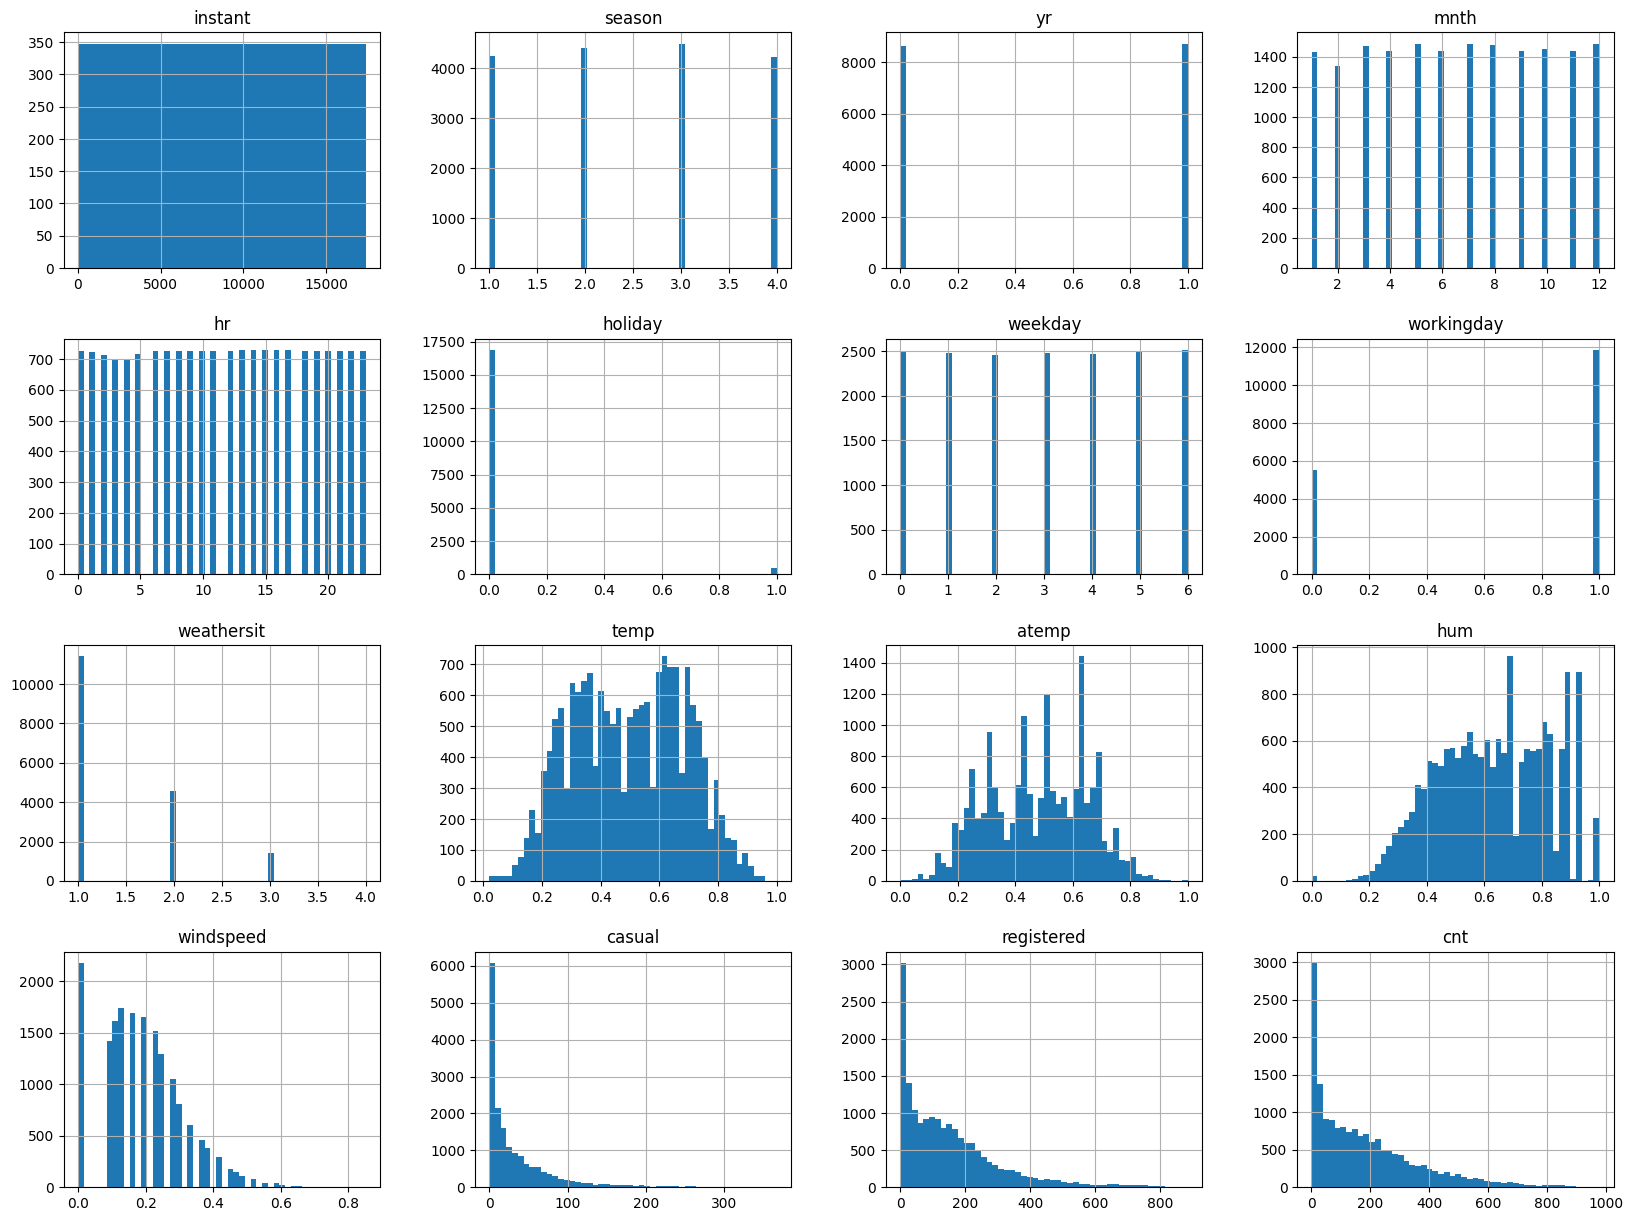

In [50]:
%matplotlib inline
import matplotlib.pyplot as plt
data.hist(bins=50, figsize=(20,15))
plt.show()

I love graphs! This is a really nice dataset so they have made it easier for us to use it. Instant is of course just the serial number so we will drop it. 

We see that all columns from season to weathersit are categorical, so we will look into one-hot encoding the important ones. 

The rest are numerical values. I like that the continuous valued fields are all between 0 and 1, that helps reduce one more step for us.

Casual, registered, and total are all the target variables. We will be predicting just the total. A large number of target values are 0, so IDK how the models will perform on that.

Temp and atemp are fairly normally distributed. Humidity is a bit left skewed, and then windspeed is properly right skewed. Windspeed also has a large number of 0 values, so I'm not sure how the models will handle that. 

Next, lets do what the good guys do and seperate the testing data. We will do a 70-30 split.

In [51]:
data.columns

Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt'],
      dtype='object')

In [52]:
data.drop(['instant', 'casual', 'registered'], axis=1)

,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,16
1,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,40
2,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,32
3,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,13
4,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,2012-12-31,1,1,12,19,0,1,1,2,0.26,0.2576,0.60,0.1642,119
17375,2012-12-31,1,1,12,20,0,1,1,2,0.26,0.2576,0.60,0.1642,89
17376,2012-12-31,1,1,12,21,0,1,1,1,0.26,0.2576,0.60,0.1642,90
17377,2012-12-31,1,1,12,22,0,1,1,1,0.26,0.2727,0.56,0.1343,61


In [53]:
X_full = data[['dteday', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed']]
        
y_full = data['cnt']

In [54]:
from sklearn.model_selection import train_test_split


X, X_test, y, y_test = train_test_split(X_full, y_full,
                                                    random_state=42, 
                                                    test_size=0.3, 
                                                    shuffle=True)

Okay, now we forget about the test set and only work with X and y. Onward!

We will choose RMSE as our error metric for now. This might change later if I see MAE as a better choice.

We will now begin visualising the data in some detail.

In [55]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12165 entries, 11229 to 15795
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   dteday      12165 non-null  object 
 1   season      12165 non-null  int64  
 2   yr          12165 non-null  int64  
 3   mnth        12165 non-null  int64  
 4   hr          12165 non-null  int64  
 5   holiday     12165 non-null  int64  
 6   weekday     12165 non-null  int64  
 7   workingday  12165 non-null  int64  
 8   weathersit  12165 non-null  int64  
 9   temp        12165 non-null  float64
 10  atemp       12165 non-null  float64
 11  hum         12165 non-null  float64
 12  windspeed   12165 non-null  float64
dtypes: float64(4), int64(8), object(1)
memory usage: 1.3+ MB


In [56]:
X.head()

,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed
11229,2012-04-18,2,1,4,2,0,3,1,2,0.50,0.4848,0.42,0.1940
6334,2011-09-26,4,0,9,12,0,1,1,2,0.68,0.6364,0.79,0.1642
11060,2012-04-11,2,1,4,0,0,3,1,1,0.34,0.3030,0.36,0.4179
12346,2012-06-03,2,1,6,15,0,0,0,1,0.70,0.6364,0.34,0.0000
15437,2012-10-10,4,1,10,10,0,3,1,1,0.56,0.5303,0.52,0.2985


I expect there to be some correlation with holidays and number of bikes. Lets explore that.

In [57]:
corr=data.corr()

<ipython-input-57-c0bda979f113>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr=data.corr()


In [58]:
corr['cnt'].sort_values(ascending=False)

cnt           1.000000
registered    0.972151
casual        0.694564
temp          0.404772
atemp         0.400929
hr            0.394071
instant       0.278379
yr            0.250495
season        0.178056
mnth          0.120638
windspeed     0.093234
workingday    0.030284
weekday       0.026900
holiday      -0.030927
weathersit   -0.142426
hum          -0.322911
Name: cnt, dtype: float64

Some very interesting patterns here. Temperature(and apparent temp) has a high correlation with count, as expected. But so does the hour of the day, meaning more people go out to cycle later in the day. Strong negative correlation is also seen with humidity, meaning higher humidity discourages people to go out to cycle. Surprisingly, holidays have a fairly insignificant correlation with count, but that might be attributable to something else. 

Lets look at some graphs.

array([[<Axes: xlabel='instant', ylabel='instant'>,
        <Axes: xlabel='season', ylabel='instant'>,
        <Axes: xlabel='yr', ylabel='instant'>,
        <Axes: xlabel='mnth', ylabel='instant'>,
        <Axes: xlabel='hr', ylabel='instant'>,
        <Axes: xlabel='holiday', ylabel='instant'>,
        <Axes: xlabel='weekday', ylabel='instant'>,
        <Axes: xlabel='workingday', ylabel='instant'>,
        <Axes: xlabel='weathersit', ylabel='instant'>,
        <Axes: xlabel='temp', ylabel='instant'>,
        <Axes: xlabel='atemp', ylabel='instant'>,
        <Axes: xlabel='hum', ylabel='instant'>,
        <Axes: xlabel='windspeed', ylabel='instant'>,
        <Axes: xlabel='casual', ylabel='instant'>,
        <Axes: xlabel='registered', ylabel='instant'>,
        <Axes: xlabel='cnt', ylabel='instant'>],
       [<Axes: xlabel='instant', ylabel='season'>,
        <Axes: xlabel='season', ylabel='season'>,
        <Axes: xlabel='yr', ylabel='season'>,
        <Axes: xlabel='mnth', ylabel=

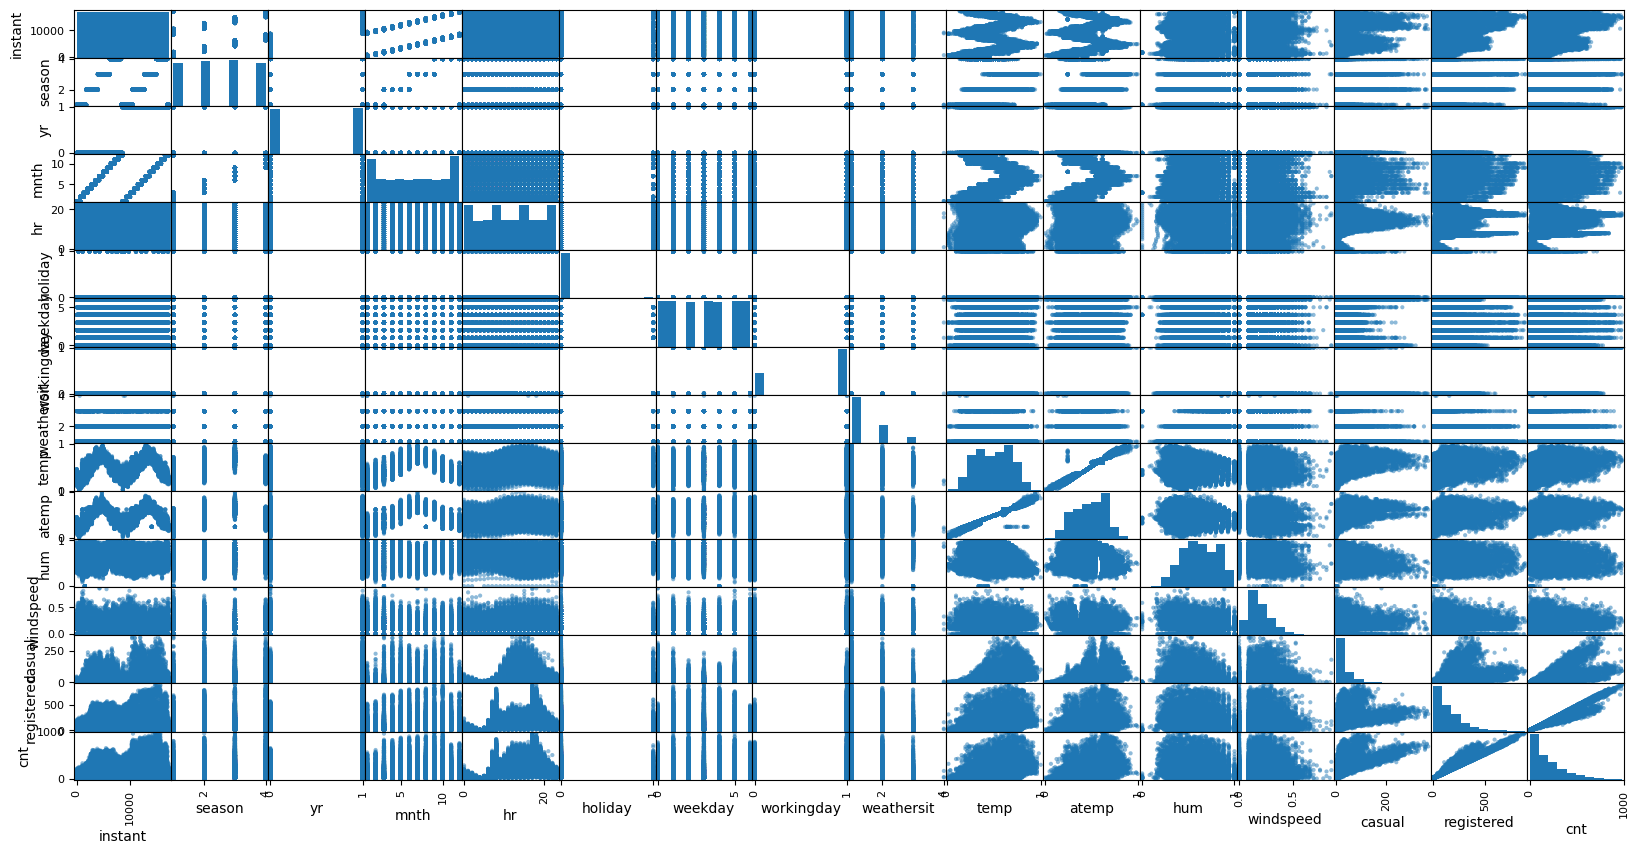

In [59]:
from pandas.plotting import scatter_matrix
scatter_matrix(data, figsize=(20,10))

Thats a lot of graphs man. But we understand the correlation from the numbers too. So we focus on **temperature, humidity**, and **hour of day** for now, and **weather situation**, **season, and month** to a lesser extent.

The book after this does some experiments with attribute combinations. 

In [60]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12165 entries, 11229 to 15795
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   dteday      12165 non-null  object 
 1   season      12165 non-null  int64  
 2   yr          12165 non-null  int64  
 3   mnth        12165 non-null  int64  
 4   hr          12165 non-null  int64  
 5   holiday     12165 non-null  int64  
 6   weekday     12165 non-null  int64  
 7   workingday  12165 non-null  int64  
 8   weathersit  12165 non-null  int64  
 9   temp        12165 non-null  float64
 10  atemp       12165 non-null  float64
 11  hum         12165 non-null  float64
 12  windspeed   12165 non-null  float64
dtypes: float64(4), int64(8), object(1)
memory usage: 1.3+ MB


Theres no null values, and I dont see how creating any new columns here will help, so we will move to the next step of preapring the data: One Hot encoding. We will do this by creating dummies using pandas.get_dummies()

In [61]:

# X.info()

In [62]:
X_tree=X[['season','mnth','atemp','hum','weathersit', 'windspeed', 'hr', 'holiday',
          'weekday','workingday','temp','yr']]

X_vanilla=X[['atemp','hum']]
X_dummies = pd.get_dummies(X_tree, columns=['weathersit','season','mnth', 'hr'])
# X_tree.drop(['weathersit','season','mnth','hr'], axis=1)

X_dummies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12165 entries, 11229 to 15795
Data columns (total 52 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   atemp         12165 non-null  float64
 1   hum           12165 non-null  float64
 2   windspeed     12165 non-null  float64
 3   holiday       12165 non-null  int64  
 4   weekday       12165 non-null  int64  
 5   workingday    12165 non-null  int64  
 6   temp          12165 non-null  float64
 7   yr            12165 non-null  int64  
 8   weathersit_1  12165 non-null  uint8  
 9   weathersit_2  12165 non-null  uint8  
 10  weathersit_3  12165 non-null  uint8  
 11  weathersit_4  12165 non-null  uint8  
 12  season_1      12165 non-null  uint8  
 13  season_2      12165 non-null  uint8  
 14  season_3      12165 non-null  uint8  
 15  season_4      12165 non-null  uint8  
 16  mnth_1        12165 non-null  uint8  
 17  mnth_2        12165 non-null  uint8  
 18  mnth_3        12165 no

We face an interesting problem. Should Hour of day be treated as a categorical or numeric field? ChatGPT says decision trees and random forests can handle categorical fields directly, and since those are my favourite algorithm, we will use that first. 

Later if we are using vanilla linear regression or neural nets, we will one hot encode it. Its just that adding 24 new columns will make the data a lot messier.  

This dataset is also very nice because the numerical features are already scaled properly between 0 and 1. So we dont have to min-max scale it.

We will be starting with Random Forests. We will use scikit-learn's k-fold cross validation to get an accurate idea of our model's score without touching the test data.

In [63]:
y.median()

145.0

In [64]:
#this code is picked up mostly straight from aurelion gerons textbook. 
#it is just a simple implementation of the cross_val_scores method from sklearn.

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVR

model = RandomForestRegressor()
# model.fit(X, y)

scores = cross_val_score(model, X_tree, y, scoring="neg_mean_squared_error", cv=10)

forests_score = np.sqrt(-scores)

def display_scores(scores):
  print("Scores:", scores)
  print("Mean:", scores.mean())
  print("Standard deviation:", scores.std())

display_scores(forests_score)

Scores: [44.6548678  45.98288709 43.83830663 43.96636938 42.9359441  42.58391174
 44.06768069 47.22360621 39.87941956 47.69259472]
Mean: 44.28255879363282
Standard deviation: 2.1848970588308014


**Mean Errors:**
(Smaller is better)

Best results only

***Median target value = 145***

Decision Tree: 135

Linear Regression: 111

*Random Forests with all data: 44*

K nearest Neighbors(10 neighbors): 59

Gaussian Naive Bayes: 385

Support Vector Machines: 154



Umm. So, yeah. I tried several combinations of fields and models and some hyperparameteres and... the most complex model when provided with the maximum data produced the best results. Hmm. 

Interestingly, all the data analysis we performed did not do much. Most of these models did better when provided with the most data, including fields I previously deemed less relevent. Of course, Random Forests and Decision Trees took the entire dataset, whereas I had to produce dummies for the other models.  

Its strange to me that Vanilla Linear Regression performed better than Decision Trees, and also that Naive Bayes performed so god awfully poorly. I guess there's something I could do to improve the Naive Bayes result, but for now I am happy with the Random Forests result. 

It is notable that when the median is 145, a mean error of 44 from our best current model is not very good. Can a more complex model do better? Probably. But for now I will leave it at that. I guess our next step then would be to select the optimal hyperparametres of random forests using gridCV or randomCV so we can finetune the model for our data. So thats what we will do now.

In [66]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [30, 40, 50, 60], 'max_features': [8, 10, 12, 15]},
     {'bootstrap': [False], 'n_estimators': [30, 40, 50, 60], 'max_features': [8,10,12,15]}
]
formodel = RandomForestRegressor()
grid_search = GridSearchCV(formodel, param_grid, cv=5,
                           scoring='neg_mean_squared_error', 
                           return_train_score=True)
grid_search.fit(X_tree, y)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [8, 10, 12, 15],
                          'n_estimators': [30, 40, 50, 60]},
                         {'bootstrap': [False], 'max_features': [8, 10, 12, 15],
                          'n_estimators': [30, 40, 50, 60]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [67]:
grid_search.best_params_

{'max_features': 10, 'n_estimators': 50}

In [68]:
sorted(grid_search.cv_results_['mean_test_score'])

[-3546.4371834269537,
 -3546.116032239005,
 -3541.854701939991,
 -3540.708058592501,
 -3537.672674347513,
 -3536.080001233045,
 -3526.581184085492,
 -3526.352862195735,
 -2386.295260218295,
 -2353.0824688450475,
 -2334.4131671419027,
 -2310.749097227931,
 -2132.2210000228342,
 -2131.771460300125,
 -2109.572764097596,
 -2098.4338653250825,
 -2090.9076452313248,
 -2078.6877743902382,
 -2076.9473092147323,
 -2072.8945881968216,
 -2071.2801637091457,
 -2062.5837625145423,
 -2059.96557521728,
 -2058.6402941471433,
 -2047.912369361385,
 -2046.334849846679,
 -2040.2601892880302,
 -2036.4748540350276,
 -2036.2207148914372,
 -2016.239298737474,
 -2015.0402324676008,
 -2014.115534651251]

So the lowest error is 44, which is at par with the result Random Forests automatically generated for us. Even though gridCV didnt do much for us here, atleast I learned to use it!

Moment of truth. Lets evaluate the model on the test set now. Final showdown.

In [69]:
from sklearn.metrics import mean_squared_error

model = grid_search.best_estimator_

X_real = X_test[['season','mnth','atemp','hum','weathersit', 'windspeed', 'hr', 'holiday',
          'weekday','workingday','temp','yr']]

pred = model.predict(X_real)

mean_squared_error(y_test, pred, squared = False)


41.46313076878663

Yay! A mean scored error of 41 on the final test dataset is pretty nice, and quite close to the trained error too. 

Alright, I am happy with the current state of this project. This has been fun. Maybe someone will actually read this notebook, and even come this far down! If so, hello there, thanks for reading my notebook! i will continue to improve my skills in this subject. 

Cheers,

Sid